In [1]:
from IPython.core.display import display, Markdown, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_108855/1701614512.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, Markdown, HTML


In [2]:
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
import epics

In [4]:
from bact_analysis.utils.preprocess import rename_doublicates

In [5]:
pv_s = epics.PV('Pierre:DT:beam:s')
pv_names = epics.PV('Pierre:DT:beam:names')

In [6]:
def for_plane(plane):
    assert plane in ["x", "y"]
    pv_nu = epics.PV(f'Pierre:DT:beam:nu:{plane}')
    pv_alpha = epics.PV(f'Pierre:DT:beam:alpha:{plane}')
    pv_beta = epics.PV(f'Pierre:DT:beam:beta:{plane}')
    
    return [pv.get() for pv in (pv_alpha, pv_beta, pv_nu)]
    

In [7]:
alpha_x, beta_x, mu_x = for_plane("x")
alpha_y, beta_y, mu_y = for_plane("y")


In [8]:
dmu_x = mu_x[1:] - mu_x[:-1]
dmu_x.shape

(1361,)

In [9]:
names_twin, s_twin= [pv.get() for pv in (pv_names, pv_s)]


names_twin

In [10]:
names_twin

array(['start', 'dg9l2d1r', 'm_fomz2d1r', ..., 'm_fomz1d1r', 'dg9l1d1r',
       'ringend'], dtype='<U14')

In [11]:
double_used_names, pos_names_without_doublets = rename_doublicates(names_twin.tolist())
double_used_names

{'blm_s1mt1r': 2}

In [12]:
twiss = xr.DataArray(name="twiss", 
                    data=[[alpha_x, alpha_y], [beta_x, beta_y], [mu_x, mu_y]], dims=["par", "plane", "pos"], coords=[["alpha", "beta", "mu"], ["x","y"], pos_names_without_doublets])
mu = xr.DataArray(name="mu", data=[mu_x, mu_y], dims=["plane", "pos"], coords=[["x","y"], pos_names_without_doublets])
mu

<xarray.DataArray 'mu' (plane: 2, pos: 1362)>
array([[0.00000000e+00, 5.81935945e-03, 5.81935945e-03, ...,
        1.78436307e+01, 1.78484612e+01, 1.78484612e+01],
       [0.00000000e+00, 2.86302743e-02, 2.86302743e-02, ...,
        6.70274883e+00, 6.72553623e+00, 6.72553623e+00]])
Coordinates:
  * plane    (plane) <U1 'x' 'y'
  * pos      (pos) <U14 'start' 'dg9l2d1r' 'm_fomz2d1r' ... 'dg9l1d1r' 'ringend'

In [13]:
s = xr.DataArray(name="s", data=s_twin, dims=["pos"], coords=[pos_names_without_doublets])

In [14]:
ttwiss2 = xr.merge([twiss, mu, s])
ttwiss2

<xarray.Dataset>
Dimensions:  (par: 3, plane: 2, pos: 1362)
Coordinates:
  * par      (par) <U5 'alpha' 'beta' 'mu'
  * plane    (plane) <U1 'x' 'y'
  * pos      (pos) <U14 'start' 'dg9l2d1r' 'm_fomz2d1r' ... 'dg9l1d1r' 'ringend'
Data variables:
    twiss    (par, plane, pos) float64 0.09199 0.05523 0.05523 ... 6.726 6.726
    mu       (plane, pos) float64 0.0 0.005819 0.005819 ... 6.703 6.726 6.726
    s        (pos) float64 0.0 0.6155 0.6155 1.137 ... 239.5 239.5 240.0 240.0

In [17]:
ttwiss = (
    xr.Dataset(dict(beta=ttwiss2.twiss.sel(par="beta")))
    .assign(dict(mu=ttwiss2.twiss.sel(par="mu"), ds=ttwiss2.s))
)

# .rename(index="pos")
ttwiss = ttwiss.assign(mu=ttwiss.mu).assign_coords(dict(pos=pos_names_without_doublets))
ttwiss

<xarray.Dataset>
Dimensions:  (plane: 2, pos: 1362)
Coordinates:
    par      <U5 'beta'
  * plane    (plane) <U1 'x' 'y'
  * pos      (pos) <U14 'start' 'dg9l2d1r' 'm_fomz2d1r' ... 'dg9l1d1r' 'ringend'
Data variables:
    beta     (plane, pos) float64 16.88 16.79 16.79 16.75 ... 3.725 3.482 3.482
    mu       (plane, pos) float64 0.0 0.005819 0.005819 ... 6.703 6.726 6.726
    ds       (pos) float64 0.0 0.6155 0.6155 1.137 ... 239.5 239.5 240.0 240.0

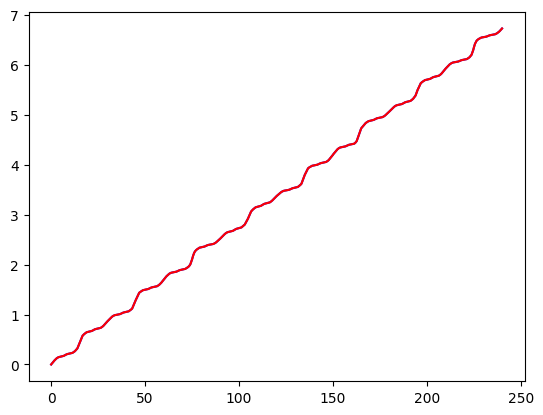

In [18]:
plt.plot(
    ttwiss.ds, ttwiss.mu.sel(plane="y"), 'b-',
    s_twin, mu_y, 'r-',
    
)

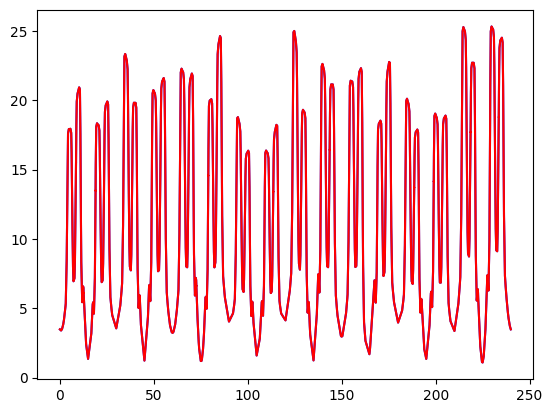

In [20]:
plt.plot(
    ttwiss.ds, ttwiss.beta.sel(plane="y"), 'b-',
    s_twin, beta_y, 'r-',
    
)

In [21]:
ttwiss.to_netcdf('bessyii_twiss_thor_scsi_from_twin.nc')

In [22]:
pwd

'/home/waheed/workspace/bact/custom/bessyii/analysis/notebooks'

In [23]:
ls -ltr

total 556
-rw-rw-r-- 1 waheed waheed  13432 Nov  7  2022 bba_analysis_tunes.py
-rw-rw-r-- 1 waheed waheed  21814 Nov  7  2022 bba_analysis_tunes.ipynb
-rw-rw-r-- 1 waheed waheed  10212 Jun  5 19:14 sextupole_response.py
-rw-rw-r-- 1 waheed waheed  41268 Jun 29 10:59 quadrupole_calibration_factors_from_at.ipynb
-rw-rw-r-- 1 waheed waheed  40048 Jun 29 10:59 bba_analysis.ipynb
-rw-rw-r-- 1 waheed waheed  23964 Jun 29 10:59 comparing_bba_data.ipynb
-rw-rw-r-- 1 waheed waheed   8080 Jun 29 10:59 analysis_bba_data.ipynb
-rw-rw-r-- 1 waheed waheed  21403 Jun 29 10:59 sextupole_response.ipynb
-rw-rw-r-- 1 waheed waheed  21628 Jun 29 10:59 tune_test.ipynb
-rw-rw-r-- 1 waheed waheed  17144 Jun 29 13:48 inspect_catalog.ipynb
-rw-rw-r-- 1 waheed waheed 149490 Jul  6 15:31 bessyii_twiss_thor_scsi_from_twin.nc
-rw-rw-r-- 1 waheed waheed 173160 Jul  6 15:31 twin_twiss_to_netcdf.ipynb
